In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, datasets
from tqdm import tqdm
import numpy as np
from torch.amp import GradScaler, autocast
import timm
from timm.data import Mixup
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score
from PIL import Image
from timm.models.convnext import ConvNeXtBlock
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split

c:\Users\10955\anaconda3\envs\vitiligo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


self-supervied trainging

In [ ]:
class Config:
    augment_ratio = 4
    data_dir ='../../../../datasets/data.csv'
    img_size = 224
    patch_size = 8
    mask_ratio = 0.75
    batch_size = 8
    weight_decay = 0.05
    device = "cuda" if torch.cuda.is_available() else "cpu"
    num_epochs = 30
    learning_rate = 1e-4
    patience = 10 
    save_dir = '../checkpoints/v3'
    resume_training = False
    def __init__(self):
        os.makedirs(self.save_dir, exist_ok=True)

config = Config()



Original datasize: 605 pairs
train_dataset_original: 484 pairs
val_dataset_original: 121 pairs
train_dataset: 2420 pairs


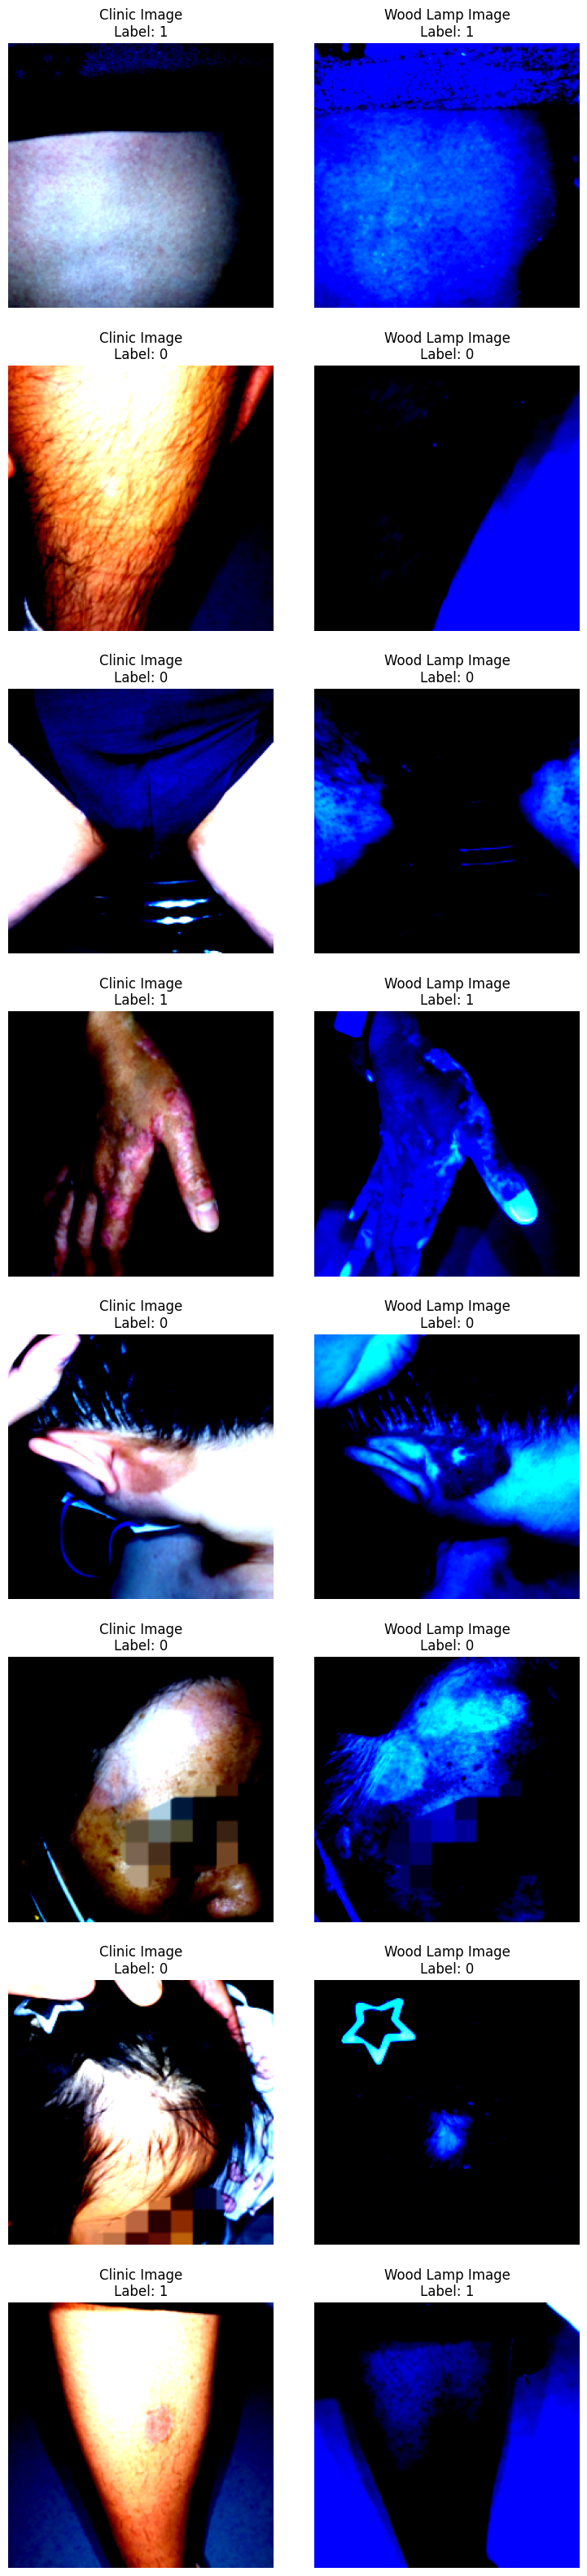

In [ ]:
import random
import matplotlib.pyplot as plt

class VitiligoDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.grouped = self.data.groupby(['pair_id', 'stability'])

    def __len__(self):
        return len(self.grouped.groups)

    def __getitem__(self, idx):
        pair_id, stability = list(self.grouped.groups.keys())[idx]
        pairs = self.grouped.get_group((pair_id, stability))
        clinic = pairs[pairs['image_type'] == 'clinic']
        wood = pairs[pairs['image_type'] == 'wood']
        clinic_path = clinic['image_path'].values[0]
        wood_path = wood['image_path'].values[0]
        clinic_image = Image.open(clinic_path).convert('RGB')
        wood_image = Image.open(wood_path).convert('RGB')
        if self.transform:
            clinic_image = self.transform(clinic_image)
            wood_image = self.transform(wood_image)
        label = 1 if stability == 'stable' else 0
        label = torch.tensor(label, dtype=torch.long)
        return clinic_image, wood_image, label


class AugmentedMixedDataset(Dataset):
    def __init__(self, original_dataset, transform, original_transform, augment_ratio=4):

        self.original_dataset = original_dataset
        self.transform = transform  
        self.original_transform = original_transform  
        self.augment_ratio = augment_ratio
        self.original_indices = list(range(len(original_dataset)))
        self.augmented_indices = list(range(len(original_dataset))) * augment_ratio
    
    def __len__(self):
        return len(self.original_indices) + len(self.augmented_indices)
    
    def __getitem__(self, idx):
        is_original = idx < len(self.original_indices)
        
        if is_original:
            idx_in_original = idx
            c_img, w_img, label = self.original_dataset[idx_in_original]
            c_img = self.original_transform(c_img)
            w_img = self.original_transform(w_img)
        else:
            idx_in_augmented = idx - len(self.original_indices)
            original_idx = self.augmented_indices[idx_in_augmented]
            c_img, w_img, label = self.original_dataset[original_idx]
            c_img_pil = transforms.ToPILImage()(c_img)
            w_img_pil = transforms.ToPILImage()(w_img)
            c_img_aug, w_img_aug = self.transform(c_img_pil, w_img_pil)
            c_img, w_img = c_img_aug, w_img_aug
        
        return c_img, w_img, label


class DualImageTransform:
    def __init__(self, transform):
        self.transform = transform
    
    def __call__(self, img1, img2):
        seed = random.randint(0, 2**32 - 1)
        for t in self.transform.transforms:
            random.seed(seed)
            img1 = t(img1)
            random.seed(seed)
            img2 = t(img2)
        return img1, img2


class LabColorTransform:
    def __init__(self, brightness_scale=0.1, a_scale=0.2, b_scale=0.2, p=0.5):
        self.brightness_scale = brightness_scale
        self.a_scale = a_scale
        self.b_scale = b_scale
        self.p = p
    
    def __call__(self, img):
        if random.random() > self.p:
            return img
        
        lab_img = img.convert('LAB')
        lab_array = np.array(lab_img)
        L, a, b = lab_array[:, :, 0], lab_array[:, :, 1], lab_array[:, :, 2]
        
        brightness_shift = random.uniform(-self.brightness_scale, self.brightness_scale)
        L = np.clip(L + brightness_shift * 100, 0, 100)
        
        a_shift = random.uniform(-self.a_scale, self.a_scale)
        a = np.clip(a + a_shift * 127, -128, 127)
        
        b_shift = random.uniform(-self.b_scale, self.b_scale)
        b = np.clip(b + b_shift * 127, -128, 127)
        
        lab_array[:, :, 0] = L
        lab_array[:, :, 1] = a
        lab_array[:, :, 2] = b
        return Image.fromarray(lab_array, mode='LAB').convert('RGB')


def create_timm_transforms(backbone, train=True):

    pretrained_cfg = backbone.pretrained_cfg if hasattr(backbone, 'pretrained_cfg') else {}

    data_config = timm.data.resolve_data_config(pretrained_cfg, verbose=False)

    
    if train:

        transform = timm.data.create_transform(
            input_size=data_config['input_size'],
            is_training=True,
            color_jitter=data_config.get('color_jitter', 0.4),
            auto_augment=data_config.get('auto_augment', None),
            re_prob=data_config.get('reprob', 0.25),
            re_mode=data_config.get('remode', 'pixel'),
            re_count=data_config.get('recount', 1),
            mean=data_config.get('mean', timm.data.constants.IMAGENET_DEFAULT_MEAN),
            std=data_config.get('std', timm.data.constants.IMAGENET_DEFAULT_STD),
        )
    else:

        transform = timm.data.create_transform(
            input_size=data_config['input_size'],
            is_training=False,
            mean=data_config.get('mean', timm.data.constants.IMAGENET_DEFAULT_MEAN),
            std=data_config.get('std', timm.data.constants.IMAGENET_DEFAULT_STD),
        )
    return transform


def get_augmentation_transform(timm_train_transform, img_size=None):

    if img_size is None:
        img_size = timm_train_transform.transforms[0].size[0]  
    
    timm_transform_list = []
    for t in timm_train_transform.transforms:
        if isinstance(t, (transforms.ToTensor, transforms.Normalize)):
            break
        timm_transform_list.append(t)
    transform = transforms.Compose([
        *timm_transform_list,
        transforms.RandomRotation(degrees=15),
        LabColorTransform(),  
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
        transforms.RandomApply([transforms.RandomAdjustSharpness(sharpness_factor=2)], p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=timm.data.constants.IMAGENET_DEFAULT_MEAN,
            std=timm.data.constants.IMAGENET_DEFAULT_STD
        )
    ])
    return transform

def visualize_dataset(dataset, num_samples=8, figsize_per_sample=(4, 4), dpi=100):

 
    total_figsize = (figsize_per_sample[0] * 2, figsize_per_sample[1] * num_samples)
    
    plt.figure(figsize=total_figsize, dpi=dpi)
    for i in range(num_samples):
        c_img, w_img, label = dataset[i]
        
 
        mean = np.array(timm.data.constants.IMAGENET_DEFAULT_MEAN)
        std = np.array(timm.data.constants.IMAGENET_DEFAULT_STD)
        c_img_np = c_img.permute(1, 2, 0).cpu().numpy()
        w_img_np = w_img.permute(1, 2, 0).cpu().numpy()
        
        c_img_np = c_img_np * std + mean
        w_img_np = w_img_np * std + mean
        c_img_np = np.clip(c_img_np, 0, 1)
        w_img_np = np.clip(w_img_np, 0, 1)
        
    
        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(c_img_np)
        plt.title(f'Clinic Image\nLabel: {label.item()}', fontsize=12)
        plt.axis('off')
        
   
        plt.subplot(num_samples, 2, 2*i+2)
        plt.imshow(w_img_np)
        plt.title(f'Wood Lamp Image\nLabel: {label.item()}', fontsize=12)
        plt.axis('off')
    
   
    plt.tight_layout(pad=2.0)


backbone = timm.create_model("convnextv2_tiny", checkpoint_path='../../../../outputs/checkpoints/proposed/pytorch_model.bin')
    
original_dataset = VitiligoDataset(csv_file='../../../../datasets/data.csv')
print(f"Original datasize: {len(original_dataset)} pairs")


train_size = int(0.8 * len(original_dataset))
val_size = len(original_dataset) - train_size
train_dataset_original, val_dataset_original = torch.utils.data.random_split(
    original_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)
print(f"train_dataset_original: {len(train_dataset_original)} pairs")
print(f"val_dataset_original: {len(val_dataset_original)} pairs")


timm_train_transform = create_timm_transforms(backbone, train=True)
timm_val_transform = create_timm_transforms(backbone, train=False)


train_augment_transform = get_augmentation_transform(timm_train_transform)
train_original_transform = timm_val_transform  



train_dataset = AugmentedMixedDataset(
    original_dataset=train_dataset_original,
    transform=DualImageTransform(train_augment_transform),
    original_transform=train_original_transform,
    augment_ratio=config.augment_ratio)

print(f"train_dataset: {len(train_dataset)} pairs")
val_dataset = val_dataset_original
val_dataset.dataset.transform = timm_val_transform


visualize_dataset(train_dataset)


train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Config.batch_size, shuffle=False)




In [ ]:
backbone = timm.create_model("convnextv2_tiny", checkpoint_path='../../../../outputs/checkpoints/proposed/pytorch_model.bin')

def count_layers(model, depth=0):
    layer_count = 0
    for _, child in model.named_children():
        layer_count += 1
        layer_count += count_layers(child, depth + 1)
    return layer_count

total_layers = count_layers(backbone)
print(f"\nTotal layers (recursive count): {total_layers}")


Total layers (recursive count): 248


dataloader

In [5]:
from collections import Counter




train_labels = []
for _, _, label in train_dataset:
    train_labels.append(label.item())

class_counts = Counter(train_labels)
total_samples = len(train_labels)
class_percentages = {cls: count / total_samples * 100 for cls, count in class_counts.items()}


print("Distribution:")
for cls, count in class_counts.items():
    print(f"Classes {cls}: {count} samples ({class_percentages[cls]:.2f}%)")


Distribution:
Classes 1: 1255 samples (51.86%)
Classes 0: 1165 samples (48.14%)


Model

In [ ]:
class ConvQKVAttention(nn.Module):
    def __init__(self, in_channels, out_channels=None, num_heads=8, num_iterations=3, sfs_scale=2, device='cuda'):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels or in_channels
        self.num_heads = num_heads
        self.num_iterations = num_iterations
        self.sfs_scale = sfs_scale

        self.sfs_avg_pool = nn.AvgPool2d(kernel_size=sfs_scale, stride=sfs_scale)
        self.sfs_max_pool = nn.MaxPool2d(kernel_size=sfs_scale, stride=sfs_scale)
        self.sfs_lambda = nn.Parameter(torch.tensor(0.5)) 

        self.q_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.k_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.v_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

        self.o_conv = nn.Conv2d(out_channels, out_channels, kernel_size=1)

        self.ffn = nn.Sequential(
            nn.Conv2d(out_channels, out_channels * 4, kernel_size=1),
            nn.GELU(),
            nn.Conv2d(out_channels * 4, out_channels, kernel_size=1)
        )

        self.alpha = nn.Parameter(torch.tensor(1.0))
        self.beta = nn.Parameter(torch.tensor(1.0))
        self.gamma = nn.Parameter(torch.tensor(1.0))
        self.delta = nn.Parameter(torch.tensor(1.0))

        self.fusion = nn.Sequential(
            nn.Conv2d(self.out_channels * 2, self.out_channels, kernel_size=1),
            nn.GELU(),
            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=1)
        ).to(device)

    def _sfs(self, x):
        """Spatial Feature Shrinking with mixed pooling."""
        avg_pool = self.sfs_avg_pool(x)
        max_pool = self.sfs_max_pool(x)
        mixed_pool = self.sfs_lambda * avg_pool + (1 - self.sfs_lambda) * max_pool
        return mixed_pool

    def _cfe(self, x_main, x_aux):
        """Cross-modal Feature Enhancement (CFE) for one branch."""
        x_main = self._sfs(x_main)
        x_aux = self._sfs(x_aux)

        B, C, H, W = x_main.shape
        head_dim = C // self.num_heads

        q = self.q_conv(x_aux).view(B, self.num_heads, head_dim, H * W).transpose(2, 3)  
        k = self.k_conv(x_main).view(B, self.num_heads, head_dim, H * W).transpose(2, 3)  
        v = self.v_conv(x_main).view(B, self.num_heads, head_dim, H * W).transpose(2, 3) 

        attention_scores = torch.matmul(q, k.transpose(-2, -1)) / (head_dim ** 0.5)  
        attention_weights = torch.softmax(attention_scores, dim=-1)

        z = torch.matmul(attention_weights, v)  
        z = z.transpose(2, 3).contiguous().view(B, C, H, W)  

        z = self.o_conv(z)
        t_prime = self.alpha * z + self.beta * x_main

        t_enhanced = self.gamma * t_prime + self.delta * self.ffn(t_prime)

        t_enhanced = F.interpolate(t_enhanced, scale_factor=self.sfs_scale, mode='bilinear', align_corners=False)

        return t_enhanced, attention_weights

    def forward(self, x1, x2):
        """Iterative Cross-modal Feature Enhancement (ICFE)."""

        t_clinic = x1
        t_wood = x2

        clinic_attention_weights = []
        wood_attention_weights = []
        for _ in range(self.num_iterations):
            t_clinic, clinic_attention = self._cfe(t_clinic, t_wood)
            t_wood, wood_attention = self._cfe(t_wood, t_clinic)
            clinic_attention_weights.append(clinic_attention)
            wood_attention_weights.append(wood_attention)

        fused_features = self.fusion(torch.cat([t_clinic, t_wood], dim=1))

        return fused_features, (clinic_attention_weights, wood_attention_weights)

class ConvNeXtBlock(nn.Module):
    """Placeholder for ConvNeXtBlock (assumed to be defined elsewhere)."""
    def __init__(self, dim, drop_path=0.0):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim)
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.drop_path = nn.Identity() if drop_path == 0 else nn.Dropout(drop_path)

    def forward(self, x):
        input = x
        x = self.conv(x)
        x = x.permute(0, 2, 3, 1) 
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        x = x.permute(0, 3, 1, 2) 
        x = input + self.drop_path(x)
        return x

class MaskGenerator:
    def __init__(self, input_size=224, patch_size=16, mask_ratio=0.75):
        self.input_size = input_size
        self.patch_size = patch_size
        self.mask_ratio = mask_ratio
        self.num_patches = (input_size // patch_size) ** 2
        self.num_masked = int(self.num_patches * mask_ratio)
    
    def __call__(self):
        mask_indices = np.random.permutation(self.num_patches)[:self.num_masked]
        mask = np.ones(self.num_patches, dtype=np.int64)
        mask[mask_indices] = 0
        mask = torch.tensor(mask, dtype=torch.bool)
        return mask



class ConvNeXtV2MAE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
      
        self.encoder = timm.create_model(
            "convnextv2_tiny",
            pretrained=False, 
            checkpoint_path='../../../../outputs/checkpoints/proposed/pytorch_model.bin'
        )
        self.encoder.head = nn.Identity()
        for param in self.encoder.parameters():
            param.requires_grad = False
        for param in self.encoder.stages[-2:].parameters():
            param.requires_grad = True
        
        self.encoder_dim = 768
        self.encoder_proj = nn.Conv2d(self.encoder_dim, 384, kernel_size=1)
        
       
        decoder_dim = 384
        self.decoder_blocks = nn.Sequential(
            ConvNeXtBlock(decoder_dim, drop_path=0.0),
            ConvNeXtBlock(decoder_dim, drop_path=0.0),
            ConvNeXtBlock(decoder_dim, drop_path=0.0),
            ConvNeXtBlock(decoder_dim, drop_path=0.0),
        )
        
      
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(decoder_dim, decoder_dim//2, kernel_size=2, stride=2),
            ConvNeXtBlock(decoder_dim//2, drop_path=0.0),
            nn.ConvTranspose2d(decoder_dim//2, decoder_dim//4, kernel_size=2, stride=2),
            ConvNeXtBlock(decoder_dim//4, drop_path=0.0),
            nn.ConvTranspose2d(decoder_dim//4, decoder_dim//8, kernel_size=2, stride=2),
            ConvNeXtBlock(decoder_dim//8, drop_path=0.0),
            nn.ConvTranspose2d(decoder_dim//8, decoder_dim//16, kernel_size=2, stride=2),
            ConvNeXtBlock(decoder_dim//16, drop_path=0.0),
            nn.ConvTranspose2d(decoder_dim//16, decoder_dim//32, kernel_size=2, stride=2),
            nn.Conv2d(decoder_dim//32, 3, kernel_size=1),
        )
        
        self.head = nn.Linear(384, 2)
        
        self.mask_generator = MaskGenerator(
            input_size=config.img_size,
            patch_size=config.patch_size,
            mask_ratio=config.mask_ratio
        )
        
        self.conv_qkv_attention = ConvQKVAttention(
            in_channels=384,
            out_channels=384,
            num_heads=8,
            num_iterations=3,
            sfs_scale=2
        )
        
    def get_global_context(self, c_img, w_img):
        """Extract global context using cross-modal feature enhancement."""
        x1 = self.encoder.forward_features(c_img) 
        x2 = self.encoder.forward_features(w_img)
        
       
        x1 = self.encoder_proj(x1)  
        x2 = self.encoder_proj(x2)  
        
        fused_features, (rgb_attention, thermal_attention) = self.conv_qkv_attention(x1, x2)
        
       
        global_features = fused_features.mean(dim=(2, 3)) 
        
        return global_features, (rgb_attention, thermal_attention)

    def forward_encoder(self, w_img, mask):
        """Encode the masked thermal image."""
        masked_x = self.generate_masked_image(w_img, mask)
        x = self.encoder.forward_features(masked_x)  
        x = self.encoder_proj(x) 
        return x, mask
    
    def forward_decoder(self, x, mask):
        """Decode the encoded features."""
        x = self.decoder_blocks(x)
        x = self.upsample(x)
        return x, mask
    
    def forward_classification(self, c_img, w_img):
        """Perform classification using global context."""
        features, _ = self.get_global_context(c_img, w_img)
        logits = self.head(features)
        return logits
    
    def forward_loss(self, c_img, w_img, pred, mask, labels=None, mae_weight=1.0, cls_weight=10.0):
        """Compute total loss (MAE + classification)."""
        p = self.config.patch_size
        h, w = w_img.shape[2] // p, w_img.shape[3] // p
        mask = torch.as_tensor(mask, dtype=torch.bool, device=pred.device)
        mask = mask.reshape(-1, 1, h, w)
        mask = F.interpolate(mask.float(), scale_factor=p, mode='nearest').bool()

       
        mae_loss = (pred - w_img) ** 2
        mae_loss = mae_loss.mean(dim=1)  
        mae_loss = (mae_loss * (~mask.squeeze(1))).sum() / (~mask).sum()
        
  
        cls_loss = 0
        if labels is not None:
            logits = self.forward_classification(c_img, w_img)
            cls_loss = F.cross_entropy(logits, labels)
        

        total_loss = mae_weight * mae_loss + cls_weight * cls_loss
        
        return {
            'total_loss': total_loss,
            'mae_loss': mae_loss,
            'cls_loss': cls_loss
        }
    
    def generate_masked_image(self, x, mask):
        """Generate masked image based on patch mask."""
        p = self.config.patch_size
        h, w = x.shape[2] // p, x.shape[3] // p
        mask = torch.as_tensor(mask, dtype=torch.float32, device=x.device)
        mask = mask.reshape(-1, 1, h, w)
        mask = F.interpolate(mask, scale_factor=p, mode='nearest')
        return x * mask
    
    def forward(self, c_img, w_img, labels=None):
        """Forward pass combining encoding, decoding, and loss computation."""
        mask = self.mask_generator()
        mask = mask.to(w_img.device)
        mask = mask.repeat(w_img.shape[0], 1)
        
        x, mask = self.forward_encoder(w_img, mask)
        pred, mask = self.forward_decoder(x, mask)
        loss = self.forward_loss(c_img, w_img, pred, mask, labels=labels)
        
        return loss, pred, mask

Visulization

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np  

def visualize(model, data_loader, config, num_samples=4, save_path=None):

    model.eval()
    device = config.device
    model = model.to(device)
    
    with torch.no_grad():

        for i, (clinic_images, wood_images, labels) in enumerate(data_loader):
            if i >= 1:
                break
                
            clinic_images = clinic_images.to(device)[:num_samples]
            wood_images = wood_images.to(device)[:num_samples]
            labels = labels.to(device)[:num_samples]
            
            _, pred, mask = model(clinic_images, wood_images, labels)
            _, attention_maps = model.get_global_context(clinic_images, wood_images)
            

            clinic_attention, wood_attention = attention_maps
            
            mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
 
            images = wood_images.detach().cpu()
            images = images * std + mean
            pred = pred.detach().cpu()
            pred = pred * std + mean
            
            p = config.patch_size
            h, w = images.shape[2] // p, images.shape[3] // p
            mask_cpu = mask[0].detach().cpu().reshape(1, 1, h, w)
            mask_cpu = F.interpolate(mask_cpu.float(), size=(images.shape[2], images.shape[3]), mode='nearest')
            mask_cpu = mask_cpu.repeat(1, 3, 1, 1)

            if isinstance(clinic_attention, list):
                clinic_attention = clinic_attention[-1]
            if isinstance(wood_attention, list):
                wood_attention = wood_attention[-1]  

            clinic_attention = clinic_attention.mean(dim=1, keepdim=True).detach().cpu()
            wood_attention = wood_attention.mean(dim=1, keepdim=True).detach().cpu()
            
            wood_images_np = wood_images.detach().cpu() * std + mean
            wood_images_np = wood_images_np.clamp(0, 1)

            B, _, H, W = wood_images.shape
            clinic_attention = F.interpolate(clinic_attention, size=(H, W), mode='bilinear', align_corners=False)
            wood_attention = F.interpolate(wood_attention, size=(H, W), mode='bilinear', align_corners=False)

            fig, axes = plt.subplots(num_samples, 5, figsize=(25, 5 * num_samples))
            
            for i in range(num_samples):

                img_original = images[i].permute(1, 2, 0).numpy()
                axes[i, 0].imshow(img_original.clip(0, 1))
                axes[i, 0].set_title("Original Image")
                axes[i, 0].axis('off')
                
                masked_img = images[i] * mask_cpu[0].numpy()
                axes[i, 1].imshow(masked_img.permute(1, 2, 0).clip(0, 1))
                axes[i, 1].set_title("Masked Image")
                axes[i, 1].axis('off')
                
                img_reconstructed = pred[i].permute(1, 2, 0).numpy()
                axes[i, 2].imshow(img_reconstructed.clip(0, 1))
                axes[i, 2].set_title("Reconstructed Image")
                axes[i, 2].axis('off')

                clinic_attn = clinic_attention[i, 0].numpy()
                clinic_attn = (clinic_attn - clinic_attn.min()) / (clinic_attn.max() - clinic_attn.min() + 1e-8)

                clinic_attn_resized = cv2.resize(clinic_attn, (img_original.shape[1], img_original.shape[0]))

                heatmap_clinic = cv2.applyColorMap((clinic_attn_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)
                heatmap_clinic = cv2.cvtColor(heatmap_clinic, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
                overlay_clinic = cv2.addWeighted(img_original, 0.6, heatmap_clinic, 0.4, 0)
                
                axes[i, 3].imshow(overlay_clinic)
                axes[i, 3].set_title("Clinic Attention")
                axes[i, 3].axis('off')

                wood_attn = wood_attention[i, 0].numpy()
                wood_attn = (wood_attn - wood_attn.min()) / (wood_attn.max() - wood_attn.min() + 1e-8)

                wood_attn_resized = cv2.resize(wood_attn, (img_original.shape[1], img_original.shape[0]))

                heatmap_wood = cv2.applyColorMap((wood_attn_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)
                heatmap_wood = cv2.cvtColor(heatmap_wood, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
                overlay_wood = cv2.addWeighted(img_original, 0.6, heatmap_wood, 0.4, 0)
                
                axes[i, 4].imshow(overlay_wood)
                axes[i, 4].set_title("Wood Attention")
                axes[i, 4].axis('off')
            
            plt.tight_layout()
            
            if save_path:
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
            else:
                plt.show()
            
            break

C:\Temp\ipykernel_55128\2611294369.py:69: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  masked_img = images[i] * mask_cpu[0].numpy()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.245256..1.1976521].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.245256..1.2556913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2707422..1.8146782].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2707422..1.6841636].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2681736..1.8223169].
Clipping input data to the valid range for imshow wi

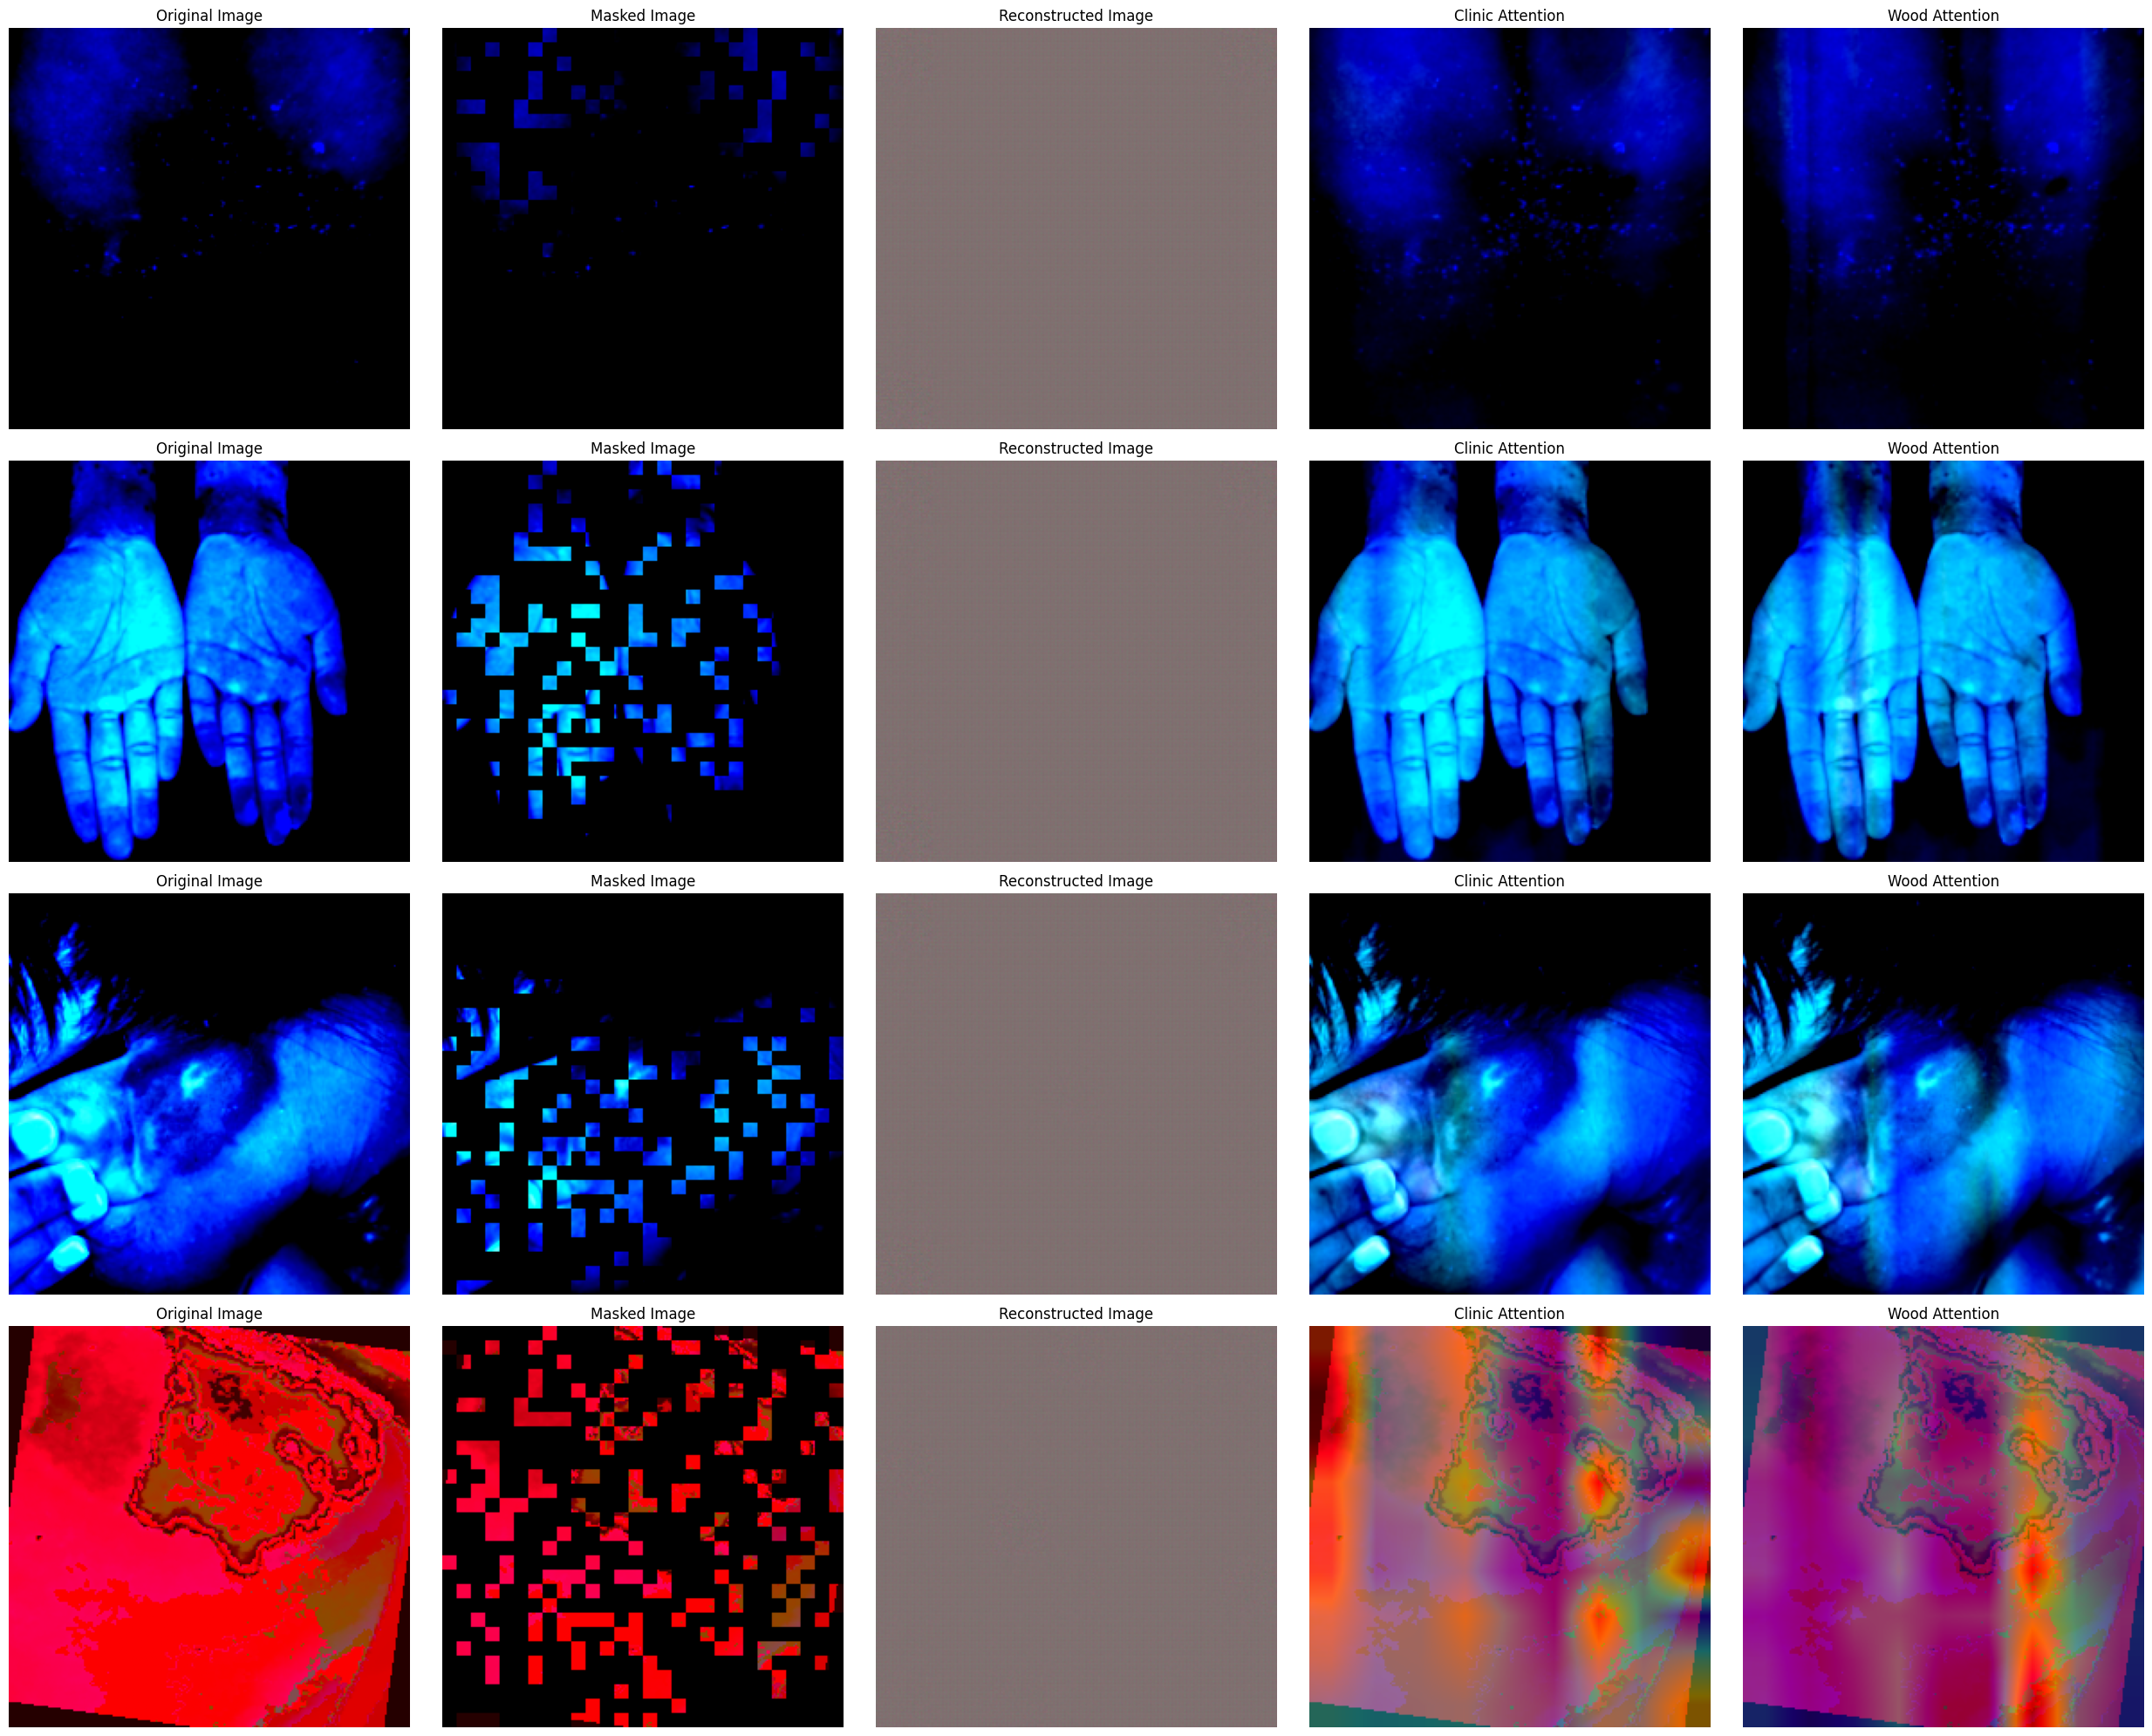

In [8]:

model = ConvNeXtV2MAE(Config).to(Config.device)
visualize(model, train_loader, Config, num_samples=4, save_path=None)

Test

In [9]:
config = Config()
model = ConvNeXtV2MAE(config).to(config.device)
model.train()
c_img, w_img, labels = next(iter(train_loader))
c_img, w_img, labels = c_img.to(config.device), w_img.to(config.device), labels.to(config.device)
loss_dict, _, _ = model(c_img, w_img, labels)
print(loss_dict)



{'total_loss': tensor(10.2166, device='cuda:0', grad_fn=<AddBackward0>), 'mae_loss': tensor(2.1104, device='cuda:0', grad_fn=<DivBackward0>), 'cls_loss': tensor(0.8106, device='cuda:0', grad_fn=<NllLossBackward0>)}


In [10]:
from sklearn.metrics import precision_score, confusion_matrix 
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for c_img, w_img, labels in val_loader:
        c_img, w_img, labels = c_img.to(config.device), w_img.to(config.device), labels.to(config.device)
        logits = model.forward_classification(c_img, w_img)
        preds = torch.argmax(logits, dim=1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())



for i, (label, pred) in enumerate(zip(all_labels, all_preds)):
    print(f"sample {i+1}: Label={label}, Pred={pred}")


precision = precision_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

print(f"precision: {precision:.4f}")
print(f"specificity: {specificity:.4f}")
print(f"cm:\n{cm}")


sample 1: Label=0, Pred=1
sample 2: Label=1, Pred=1
sample 3: Label=0, Pred=1
sample 4: Label=1, Pred=1
sample 5: Label=0, Pred=1
sample 6: Label=0, Pred=1
sample 7: Label=1, Pred=1
sample 8: Label=1, Pred=1
sample 9: Label=1, Pred=1
sample 10: Label=0, Pred=1
sample 11: Label=1, Pred=1
sample 12: Label=0, Pred=1
sample 13: Label=1, Pred=1
sample 14: Label=1, Pred=1
sample 15: Label=0, Pred=1
sample 16: Label=1, Pred=1
sample 17: Label=1, Pred=1
sample 18: Label=0, Pred=1
sample 19: Label=1, Pred=1
sample 20: Label=1, Pred=1
sample 21: Label=0, Pred=1
sample 22: Label=1, Pred=1
sample 23: Label=0, Pred=1
sample 24: Label=1, Pred=1
sample 25: Label=0, Pred=1
sample 26: Label=0, Pred=1
sample 27: Label=0, Pred=1
sample 28: Label=0, Pred=1
sample 29: Label=1, Pred=1
sample 30: Label=1, Pred=1
sample 31: Label=0, Pred=1
sample 32: Label=1, Pred=1
sample 33: Label=1, Pred=1
sample 34: Label=0, Pred=1
sample 35: Label=0, Pred=1
sample 36: Label=1, Pred=1
sample 37: Label=0, Pred=1
sample 38:

Epoch 1/30: 100%|██████████| 303/303 [10:57<00:00,  2.17s/it, cls=0.7864, loss=8.7401, mae=0.8758] 



Epoch 1 - Train: cls=0.6832, mae=5.3211, loss=12.1531, precision=0.6761, specificity=0.6275, recall=0.7219, f1=0.6983, auc=0.7528, accuracy=0.6764
Epoch 1 - Val: cls=0.6755, mae=0.8948, precision=0.4954, specificity=0.1538, recall=0.9643, f1=0.6545, auc=0.7478, accuracy=0.5289
★ Saved best model: best_model_p0.4954_s0.1538_f10.6545.pth
Checkpoint saved at epoch 1


Epoch 2/30: 100%|██████████| 303/303 [11:02<00:00,  2.19s/it, cls=0.3071, loss=6.8054, mae=3.7349] 



Epoch 2 - Train: cls=0.6198, mae=3.1505, loss=9.3490, precision=0.7521, specificity=0.7433, recall=0.7227, f1=0.7371, auc=0.8249, accuracy=0.7326
Epoch 2 - Val: cls=0.4913, mae=2.0876, precision=0.7593, specificity=0.8000, recall=0.7321, f1=0.7455, auc=0.8321, accuracy=0.7686
★ Saved best model: best_model_p0.7593_s0.8000_f10.7455.pth
Checkpoint saved at epoch 2


Epoch 3/30: 100%|██████████| 303/303 [10:54<00:00,  2.16s/it, cls=0.3954, loss=5.4256, mae=1.4719] 



Epoch 3 - Train: cls=0.5074, mae=2.1396, loss=7.2136, precision=0.8465, specificity=0.8335, recall=0.8526, f1=0.8495, auc=0.9268, accuracy=0.8434
Epoch 3 - Val: cls=0.4862, mae=1.2926, precision=0.7963, specificity=0.8308, recall=0.7679, f1=0.7818, auc=0.8613, accuracy=0.8017
★ Saved best model: best_model_p0.7963_s0.8308_f10.7818.pth
Checkpoint saved at epoch 3


Epoch 4/30: 100%|██████████| 303/303 [10:53<00:00,  2.16s/it, cls=0.3414, loss=5.4512, mae=2.0374]



Epoch 4 - Train: cls=0.4424, mae=1.6386, loss=6.0623, precision=0.8705, specificity=0.8584, recall=0.8837, f1=0.8770, auc=0.9536, accuracy=0.8715
Epoch 4 - Val: cls=0.4992, mae=0.9751, precision=0.7500, specificity=0.7692, recall=0.8036, f1=0.7759, auc=0.8473, accuracy=0.7851


Epoch 5/30: 100%|██████████| 303/303 [10:47<00:00,  2.14s/it, cls=0.2421, loss=4.5481, mae=2.1274]



Epoch 5 - Train: cls=0.3583, mae=1.5708, loss=5.1535, precision=0.9124, specificity=0.9039, recall=0.9291, f1=0.9206, auc=0.9767, accuracy=0.9169
Epoch 5 - Val: cls=0.5817, mae=0.9553, precision=0.7460, specificity=0.7538, recall=0.8393, f1=0.7899, auc=0.8868, accuracy=0.7934
Checkpoint saved at epoch 5


Epoch 6/30: 100%|██████████| 303/303 [10:40<00:00,  2.11s/it, cls=0.2483, loss=3.8273, mae=1.3438]



Epoch 6 - Train: cls=0.3151, mae=1.4722, loss=4.6234, precision=0.9308, specificity=0.9253, recall=0.9331, f1=0.9320, auc=0.9830, accuracy=0.9293
Epoch 6 - Val: cls=0.7367, mae=0.7320, precision=0.7561, specificity=0.8462, recall=0.5536, f1=0.6392, auc=0.7728, accuracy=0.7107


Epoch 7/30: 100%|██████████| 303/303 [10:39<00:00,  2.11s/it, cls=0.0006, loss=1.8218, mae=1.8153]



Epoch 7 - Train: cls=0.2515, mae=1.4715, loss=3.9865, precision=0.9507, specificity=0.9468, recall=0.9530, f1=0.9519, auc=0.9914, accuracy=0.9500
Epoch 7 - Val: cls=0.7239, mae=1.0912, precision=0.7167, specificity=0.7385, recall=0.7679, f1=0.7414, auc=0.8684, accuracy=0.7521


Epoch 8/30: 100%|██████████| 303/303 [10:42<00:00,  2.12s/it, cls=0.0314, loss=1.8588, mae=1.5449]



Epoch 8 - Train: cls=0.2451, mae=1.3973, loss=3.8478, precision=0.9445, specificity=0.9391, recall=0.9625, f1=0.9534, auc=0.9912, accuracy=0.9512
Epoch 8 - Val: cls=0.5370, mae=0.7858, precision=0.7500, specificity=0.7692, recall=0.8036, f1=0.7759, auc=0.8846, accuracy=0.7851


Epoch 9/30: 100%|██████████| 303/303 [10:41<00:00,  2.12s/it, cls=0.0041, loss=2.1052, mae=2.0646]



Epoch 9 - Train: cls=0.2159, mae=1.3400, loss=3.4989, precision=0.9589, specificity=0.9554, recall=0.9665, f1=0.9627, auc=0.9928, accuracy=0.9612
Epoch 9 - Val: cls=0.4657, mae=0.8846, precision=0.7101, specificity=0.6923, recall=0.8750, f1=0.7840, auc=0.8860, accuracy=0.7769


Epoch 10/30: 100%|██████████| 303/303 [10:40<00:00,  2.11s/it, cls=0.2208, loss=2.7320, mae=0.5238]



Epoch 10 - Train: cls=0.1690, mae=1.2931, loss=2.9832, precision=0.9607, specificity=0.9579, recall=0.9554, f1=0.9581, auc=0.9936, accuracy=0.9566
Epoch 10 - Val: cls=0.6431, mae=1.0514, precision=0.7931, specificity=0.8154, recall=0.8214, f1=0.8070, auc=0.9091, accuracy=0.8182
★ Saved best model: best_model_p0.7931_s0.8154_f10.8070.pth
Checkpoint saved at epoch 10


Epoch 11/30: 100%|██████████| 303/303 [10:57<00:00,  2.17s/it, cls=0.0183, loss=1.3516, mae=1.1690]



Epoch 11 - Train: cls=0.1343, mae=1.2700, loss=2.6125, precision=0.9684, specificity=0.9657, recall=0.9753, f1=0.9718, auc=0.9959, accuracy=0.9707
Epoch 11 - Val: cls=0.5726, mae=0.8214, precision=0.7931, specificity=0.8154, recall=0.8214, f1=0.8070, auc=0.8901, accuracy=0.8182


Epoch 12/30: 100%|██████████| 303/303 [13:12<00:00,  2.62s/it, cls=0.0061, loss=2.2009, mae=2.1399]



Epoch 12 - Train: cls=0.1299, mae=1.2590, loss=2.5577, precision=0.9720, specificity=0.9700, recall=0.9689, f1=0.9705, auc=0.9968, accuracy=0.9694
Epoch 12 - Val: cls=0.8994, mae=0.6353, precision=0.7966, specificity=0.8154, recall=0.8393, f1=0.8174, auc=0.8923, accuracy=0.8264
★ Saved best model: best_model_p0.7966_s0.8154_f10.8174.pth
Checkpoint saved at epoch 12


Epoch 13/30: 100%|██████████| 303/303 [13:07<00:00,  2.60s/it, cls=0.0083, loss=2.3275, mae=2.2449]



Epoch 13 - Train: cls=0.1341, mae=1.2653, loss=2.6064, precision=0.9731, specificity=0.9708, recall=0.9785, f1=0.9758, auc=0.9967, accuracy=0.9748
Epoch 13 - Val: cls=0.9173, mae=0.7296, precision=0.8400, specificity=0.8769, recall=0.7500, f1=0.7925, auc=0.8843, accuracy=0.8182
★ Saved best model: best_model_p0.8400_s0.8769_f10.7925.pth
Checkpoint saved at epoch 13


Epoch 14/30: 100%|██████████| 303/303 [11:16<00:00,  2.23s/it, cls=0.0099, loss=1.6559, mae=1.5573]



Epoch 14 - Train: cls=0.1219, mae=1.2557, loss=2.4751, precision=0.9756, specificity=0.9734, recall=0.9857, f1=0.9806, auc=0.9978, accuracy=0.9798
Epoch 14 - Val: cls=0.6583, mae=0.7570, precision=0.8000, specificity=0.8154, recall=0.8571, f1=0.8276, auc=0.8923, accuracy=0.8347
★ Saved best model: best_model_p0.8000_s0.8154_f10.8276.pth
Checkpoint saved at epoch 14


Epoch 15/30: 100%|██████████| 303/303 [10:48<00:00,  2.14s/it, cls=0.0382, loss=1.5612, mae=1.1796]



Epoch 15 - Train: cls=0.1261, mae=1.2133, loss=2.4740, precision=0.9675, specificity=0.9648, recall=0.9729, f1=0.9702, auc=0.9972, accuracy=0.9690
Epoch 15 - Val: cls=0.9143, mae=0.8614, precision=0.8500, specificity=0.9077, recall=0.6071, f1=0.7083, auc=0.8797, accuracy=0.7686
Checkpoint saved at epoch 15


Epoch 16/30: 100%|██████████| 303/303 [10:47<00:00,  2.14s/it, cls=0.0076, loss=1.7448, mae=1.6692]



Epoch 16 - Train: cls=0.1097, mae=1.2086, loss=2.3059, precision=0.9856, specificity=0.9845, recall=0.9809, f1=0.9832, auc=0.9980, accuracy=0.9826
Epoch 16 - Val: cls=0.9164, mae=0.9428, precision=0.7797, specificity=0.8000, recall=0.8214, f1=0.8000, auc=0.8766, accuracy=0.8099


Epoch 17/30: 100%|██████████| 303/303 [10:48<00:00,  2.14s/it, cls=0.1861, loss=2.5733, mae=0.7119]



Epoch 17 - Train: cls=0.1114, mae=1.1804, loss=2.2944, precision=0.9855, specificity=0.9845, recall=0.9761, f1=0.9808, auc=0.9979, accuracy=0.9802
Epoch 17 - Val: cls=0.9020, mae=1.2197, precision=0.7963, specificity=0.8308, recall=0.7679, f1=0.7818, auc=0.8874, accuracy=0.8017


Epoch 18/30: 100%|██████████| 303/303 [10:46<00:00,  2.13s/it, cls=0.1226, loss=2.0634, mae=0.8373]



Epoch 18 - Train: cls=0.1205, mae=1.1753, loss=2.3800, precision=0.9761, specificity=0.9742, recall=0.9777, f1=0.9769, auc=0.9973, accuracy=0.9760
Epoch 18 - Val: cls=0.9527, mae=0.8852, precision=0.8571, specificity=0.8923, recall=0.7500, f1=0.8000, auc=0.8832, accuracy=0.8264
★ Saved best model: best_model_p0.8571_s0.8923_f10.8000.pth
Checkpoint saved at epoch 18


Epoch 19/30: 100%|██████████| 303/303 [10:47<00:00,  2.14s/it, cls=0.1072, loss=1.8465, mae=0.7749]



Epoch 19 - Train: cls=0.1037, mae=1.1707, loss=2.2077, precision=0.9809, specificity=0.9794, recall=0.9801, f1=0.9805, auc=0.9984, accuracy=0.9798
Epoch 19 - Val: cls=0.6567, mae=0.9998, precision=0.7857, specificity=0.8154, recall=0.7857, f1=0.7857, auc=0.8934, accuracy=0.8017


Epoch 20/30: 100%|██████████| 303/303 [10:53<00:00,  2.16s/it, cls=0.1017, loss=1.7467, mae=0.7298]



Epoch 20 - Train: cls=0.1224, mae=1.1555, loss=2.3792, precision=0.9716, specificity=0.9691, recall=0.9817, f1=0.9766, auc=0.9974, accuracy=0.9756
Epoch 20 - Val: cls=1.0019, mae=0.4345, precision=0.7759, specificity=0.8000, recall=0.8036, f1=0.7895, auc=0.8610, accuracy=0.8017
Checkpoint saved at epoch 20


Epoch 21/30: 100%|██████████| 303/303 [11:06<00:00,  2.20s/it, cls=0.1837, loss=2.6193, mae=0.7823]



Epoch 21 - Train: cls=0.1097, mae=1.1680, loss=2.2648, precision=0.9763, specificity=0.9742, recall=0.9833, f1=0.9798, auc=0.9980, accuracy=0.9789
Epoch 21 - Val: cls=0.9246, mae=0.4734, precision=0.7963, specificity=0.8308, recall=0.7679, f1=0.7818, auc=0.8923, accuracy=0.8017


Epoch 22/30: 100%|██████████| 303/303 [24:36<00:00,  4.87s/it, cls=0.0098, loss=1.2926, mae=1.1949] 



Epoch 22 - Train: cls=0.1036, mae=1.1126, loss=2.1489, precision=0.9810, specificity=0.9794, recall=0.9849, f1=0.9829, auc=0.9987, accuracy=0.9822
Epoch 22 - Val: cls=0.9711, mae=0.5006, precision=0.7414, specificity=0.7692, recall=0.7679, f1=0.7544, auc=0.8596, accuracy=0.7686


Epoch 23/30: 100%|██████████| 303/303 [54:18<00:00, 10.76s/it, cls=0.0748, loss=1.7918, mae=1.0434]



Epoch 23 - Train: cls=0.0955, mae=1.0871, loss=2.0419, precision=0.9834, specificity=0.9820, recall=0.9904, f1=0.9869, auc=0.9988, accuracy=0.9864
Epoch 23 - Val: cls=1.1893, mae=0.4283, precision=0.7414, specificity=0.7692, recall=0.7679, f1=0.7544, auc=0.8549, accuracy=0.7686


Epoch 24/30: 100%|██████████| 303/303 [35:49<00:00,  7.09s/it, cls=0.4277, loss=4.7733, mae=0.4962]



Epoch 24 - Train: cls=0.1100, mae=1.1034, loss=2.2034, precision=0.9786, specificity=0.9768, recall=0.9833, f1=0.9809, auc=0.9985, accuracy=0.9802
Epoch 24 - Val: cls=0.7033, mae=0.4891, precision=0.7759, specificity=0.8000, recall=0.8036, f1=0.7895, auc=0.8695, accuracy=0.8017


Epoch 25/30: 100%|██████████| 303/303 [11:07<00:00,  2.20s/it, cls=0.0009, loss=1.3013, mae=1.2921]



Epoch 25 - Train: cls=0.0890, mae=1.0890, loss=1.9788, precision=0.9708, specificity=0.9682, recall=0.9817, f1=0.9762, auc=0.9978, accuracy=0.9752
Epoch 25 - Val: cls=1.0031, mae=0.4274, precision=0.8333, specificity=0.8769, recall=0.7143, f1=0.7692, auc=0.8824, accuracy=0.8017
Checkpoint saved at epoch 25


Epoch 26/30: 100%|██████████| 303/303 [11:08<00:00,  2.21s/it, cls=0.0045, loss=2.6858, mae=2.6411]



Epoch 26 - Train: cls=0.0726, mae=1.0834, loss=1.8092, precision=0.9833, specificity=0.9820, recall=0.9833, f1=0.9833, auc=0.9984, accuracy=0.9826
Epoch 26 - Val: cls=1.0900, mae=0.3774, precision=0.8200, specificity=0.8615, recall=0.7321, f1=0.7736, auc=0.8775, accuracy=0.8017


Epoch 27/30: 100%|██████████| 303/303 [11:09<00:00,  2.21s/it, cls=0.0000, loss=1.3701, mae=1.3697]



Epoch 27 - Train: cls=0.0600, mae=1.0671, loss=1.6668, precision=0.9826, specificity=0.9811, recall=0.9896, f1=0.9861, auc=0.9992, accuracy=0.9855
Epoch 27 - Val: cls=0.9852, mae=0.3367, precision=0.7705, specificity=0.7846, recall=0.8393, f1=0.8034, auc=0.8907, accuracy=0.8099


Epoch 28/30: 100%|██████████| 303/303 [11:10<00:00,  2.21s/it, cls=0.0001, loss=2.0365, mae=2.0359]



Epoch 28 - Train: cls=0.0617, mae=1.0495, loss=1.6662, precision=0.9873, specificity=0.9863, recall=0.9928, f1=0.9901, auc=0.9992, accuracy=0.9897
Epoch 28 - Val: cls=1.0006, mae=0.4306, precision=0.7541, specificity=0.7692, recall=0.8214, f1=0.7863, auc=0.8868, accuracy=0.7934
Early stopping at epoch 28: No improvement in composite metric for 10 epochs
Training completed. Best metrics: precision=0.8571, specificity=0.8923, f1=0.8000, auc=0.8832, recall=0.7500, accuracy=0.8264


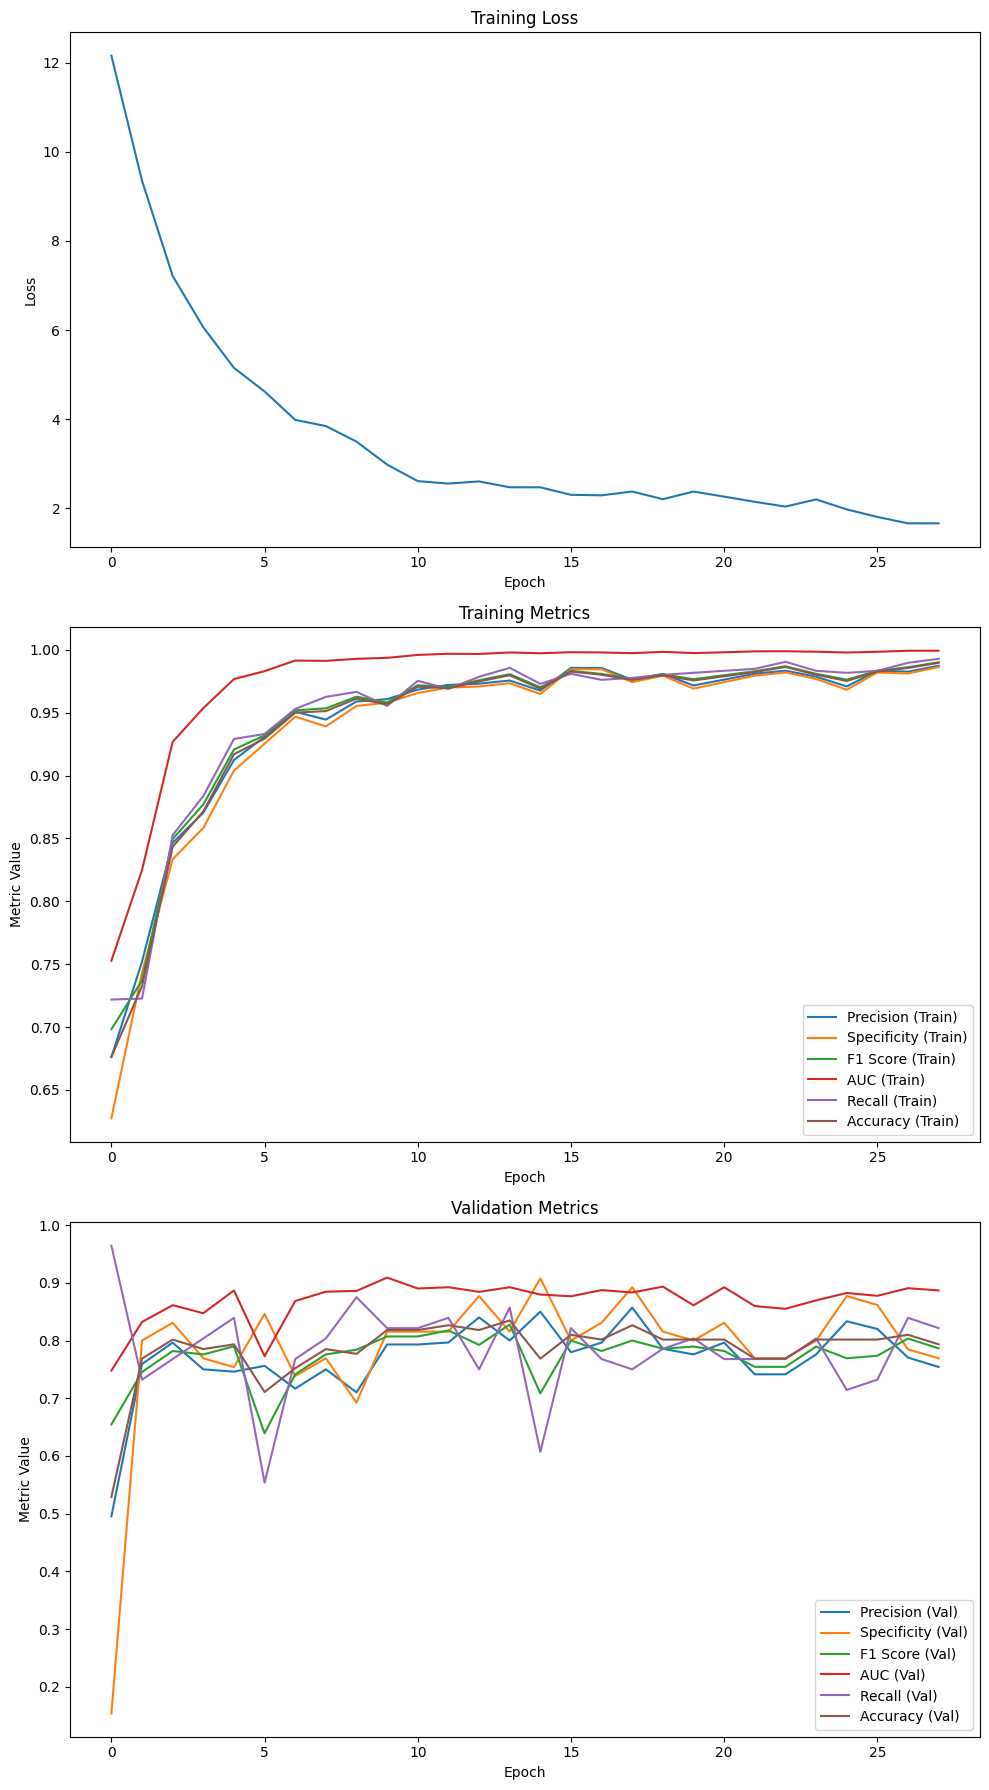

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tqdm import tqdm
import os
import time


config = Config()
model = ConvNeXtV2MAE(config).to(config.device)

optimizer = optim.AdamW(
    model.parameters(), 
    lr=config.learning_rate, 
    weight_decay=config.weight_decay
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

start_epoch = 0
best_val_metrics = 0.0
best_val_precision = 0.0
best_val_specificity = 0.0
best_val_f1 = 0.0
best_val_auc = 0.0
best_val_recall = 0.0
best_val_accuracy = 0.0
counter = 0
train_losses = []
train_precisions = []
train_specificities = []
train_f1s = []
train_aucs = []
train_recalls = []
train_accuracies = []
val_precisions = []
val_specificities = []
val_f1s = []
val_aucs = []
val_recalls = []
val_accuracies = []

checkpoint_path = os.path.join(config.save_dir, 'checkpoint.pth')
best_model_dir = config.save_dir
os.makedirs(best_model_dir, exist_ok=True)

if config.resume_training:
    checkpoint = torch.load(config.best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_precision = checkpoint['best_val_precision']
    best_val_specificity = checkpoint['best_val_specificity']
    best_val_f1 = checkpoint.get('best_val_f1', 0.0)
    best_val_auc = checkpoint.get('best_val_auc', 0.0)
    best_val_recall = checkpoint.get('best_val_recall', 0.0)
    best_val_accuracy = checkpoint.get('best_val_accuracy', 0.0)
    train_losses = checkpoint.get('train_losses', [])
    train_precisions = checkpoint.get('train_precisions', [])
    train_specificities = checkpoint.get('train_specificities', [])
    train_f1s = checkpoint.get('train_f1s', [])
    train_aucs = checkpoint.get('train_aucs', [])
    train_recalls = checkpoint.get('train_recalls', [])
    train_accuracies = checkpoint.get('train_accuracies', [])
    val_precisions = checkpoint.get('val_precisions', [])
    val_specificities = checkpoint.get('val_specificities', [])
    val_f1s = checkpoint.get('val_f1s', [])
    val_aucs = checkpoint.get('val_aucs', [])
    val_recalls = checkpoint.get('val_recalls', [])
    val_accuracies = checkpoint.get('val_accuracies', [])

for epoch in range(start_epoch, config.num_epochs):
    model.train()
    epoch_loss = 0.0
    all_mae = []
    all_cls = []
    all_preds = []
    all_labels = []
    all_probs = []
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.num_epochs}')
    
    for i, (c_img, w_img, labels) in enumerate(progress_bar):
        c_img, w_img, labels = c_img.to(config.device), w_img.to(config.device), labels.to(config.device)
        optimizer.zero_grad(set_to_none=True)
        loss_dict, _, _ = model(c_img, w_img, labels)
        loss = loss_dict['total_loss']
        loss.backward()
        optimizer.step()

        logits = model.forward_classification(c_img, w_img)
        probs = torch.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())
        epoch_loss += loss.item()
        all_mae.append(loss_dict['mae_loss'].item())
        all_cls.append(loss_dict['cls_loss'].item())
        
        if (i+1) % 20 == 0 or i == len(train_loader)-1:
            cls = loss_dict['cls_loss'].item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}", cls=f"{cls:.4f}", mae=f"{loss_dict['mae_loss'].item():.4f}")

    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)
    avg_cls = np.mean(all_cls)
    avg_mae = np.mean(all_mae)
    train_precision = precision_score(all_labels, all_preds)
    train_recall = recall_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds)
    train_auc = roc_auc_score(all_labels, all_probs) 
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()
    train_specificity = tn / (tn + fp) 
    train_accuracy = (tp + tn) / (tp + tn + fp + fn) 

    train_precisions.append(train_precision)
    train_specificities.append(train_specificity)
    train_f1s.append(train_f1)
    train_aucs.append(train_auc)
    train_recalls.append(train_recall)
    train_accuracies.append(train_accuracy)
    
    print(f"\nEpoch {epoch+1} - Train: cls={avg_cls:.4f}, mae={avg_mae:.4f}, loss={train_loss:.4f}, "
          f"precision={train_precision:.4f}, specificity={train_specificity:.4f}, "
          f"recall={train_recall:.4f}, f1={train_f1:.4f}, auc={train_auc:.4f}, accuracy={train_accuracy:.4f}")


    model.eval()
    all_preds, all_labels, all_probs, all_mae_val, all_cls_val = [], [], [], [], []
    with torch.no_grad(): 
        for c_img, w_img, labels in val_loader:
            c_img, w_img, labels = c_img.to(config.device), w_img.to(config.device), labels.to(config.device)
            loss_dict, pred, mask = model(c_img, w_img, labels)
            logits = model.forward_classification(c_img, w_img)
            probs = torch.softmax(logits, dim=1)[:, 1]
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy()) 
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_mae_val.append(loss_dict['mae_loss'].item())
            all_cls_val.append(loss_dict['cls_loss'].item())

    avg_cls_val = np.mean(all_cls_val)
    avg_mae_val = np.mean(all_mae_val)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    if len(np.unique(all_labels)) > 1:
        auc = roc_auc_score(all_labels, all_probs)
    else:
        auc = 0.0
    cm = confusion_matrix(all_labels, all_preds)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0
    else:
        specificity = 0.0
        accuracy = 0.0

    val_precisions.append(precision)
    val_specificities.append(specificity)
    val_f1s.append(f1)
    val_aucs.append(auc)
    val_recalls.append(recall)
    val_accuracies.append(accuracy)
    
    print(f"Epoch {epoch+1} - Val: cls={avg_cls_val:.4f}, mae={avg_mae_val:.4f}, "
          f"precision={precision:.4f}, specificity={specificity:.4f}, "
          f"recall={recall:.4f}, f1={f1:.4f}, auc={auc:.4f}, accuracy={accuracy:.4f}")
    
    composite_metric = precision * specificity * recall
    scheduler.step(composite_metric)

    is_best = composite_metric > best_val_metrics
    if is_best:
        best_val_metrics = composite_metric
        best_val_precision = precision
        best_val_specificity = specificity
        best_val_f1 = f1
        best_val_auc = auc
        best_val_recall = recall
        best_val_accuracy = accuracy
        counter = 0
        model_path = os.path.join(best_model_dir,
                                 f"best_model_p{precision:.4f}_s{specificity:.4f}_f1{f1:.4f}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"★ Saved best model: {os.path.basename(model_path)}")
    else:
        counter += 1

    if (epoch+1) % 5 == 0 or is_best:
        checkpoint = {
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_precision': best_val_precision,
            'best_val_specificity': best_val_specificity,
            'best_val_f1': best_val_f1,
            'best_val_auc': best_val_auc,
            'best_val_recall': best_val_recall,
            'best_val_accuracy': best_val_accuracy,
            'train_losses': train_losses,
            'train_precisions': train_precisions,
            'train_specificities': train_specificities,
            'train_f1s': train_f1s,
            'train_aucs': train_aucs,
            'train_recalls': train_recalls,
            'train_accuracies': train_accuracies,
            'val_precisions': val_precisions,
            'val_specificities': val_specificities,
            'val_f1s': val_f1s,
            'val_aucs': val_aucs,
            'val_recalls': val_recalls,
            'val_accuracies': val_accuracies,
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch+1}")

    if counter >= config.patience:
        print(f"Early stopping at epoch {epoch+1}: No improvement in composite metric for {config.patience} epochs")
        break

print(f"Training completed. Best metrics: precision={best_val_precision:.4f}, specificity={best_val_specificity:.4f}, "
      f"f1={best_val_f1:.4f}, auc={best_val_auc:.4f}, recall={best_val_recall:.4f}, accuracy={best_val_accuracy:.4f}")

def plot_training_metrics(train_losses, train_precisions, train_specificities, train_f1s, train_aucs, train_recalls, train_accuracies,
                         val_precisions, val_specificities, val_f1s, val_aucs, val_recalls, val_accuracies):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 18))

    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax2.plot(train_precisions, label='Precision (Train)')
    ax2.plot(train_specificities, label='Specificity (Train)')
    ax2.plot(train_f1s, label='F1 Score (Train)')
    ax2.plot(train_aucs, label='AUC (Train)')
    ax2.plot(train_recalls, label='Recall (Train)')
    ax2.plot(train_accuracies, label='Accuracy (Train)')
    ax2.set_title('Training Metrics')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Metric Value')
    ax2.legend()

    ax3.plot(val_precisions, label='Precision (Val)')
    ax3.plot(val_specificities, label='Specificity (Val)')
    ax3.plot(val_f1s, label='F1 Score (Val)')
    ax3.plot(val_aucs, label='AUC (Val)')
    ax3.plot(val_recalls, label='Recall (Val)')
    ax3.plot(val_accuracies, label='Accuracy (Val)')
    ax3.set_title('Validation Metrics')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Metric Value')
    ax3.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(config.save_dir, 'metrics.png'))
    plt.show()
plot_training_metrics(train_losses, train_precisions, train_specificities, train_f1s, train_aucs, train_recalls, train_accuracies,
                     val_precisions, val_specificities, val_f1s, val_aucs, val_recalls, val_accuracies)